In [1]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import multiprocessing
import os
import pprint
import re

In [2]:
import nltk
from gensim.models import word2vec as w2v
import sklearn.manifold
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rebeccapearce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rebeccapearce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
book_filenames = sorted(glob.glob('./data/*.txt'))

In [5]:
print("Found books:")
print(book_filenames)

Found books:
['./data/got1.txt', './data/got2.txt', './data/got3.txt', './data/got4.txt', './data/got5.txt']


In [6]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading './data/got1.txt'...
Corpus is now 1768657 characters long

Reading './data/got2.txt'...
Corpus is now 4065901 characters long

Reading './data/got3.txt'...
Corpus is now 6381311 characters long

Reading './data/got4.txt'...
Corpus is now 8093654 characters long

Reading './data/got5.txt'...
Corpus is now 9703229 characters long



In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [9]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [10]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
print(raw_sentence[5])
print(sentence_to_wordlist(raw_sentences[5]))

 
[u'Now', u'he', u'thought', u'of', u'them', u'as', u'old', u'friends']


In [12]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,815,530 tokens


In [13]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1


In [14]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [15]:
thrones2vec.build_vocab(sentences)

In [16]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17177


In [17]:
thrones2vec.train(sentences, total_words=token_count, epochs=100)

(140223873, 181553000)

In [18]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [19]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [20]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [21]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [23]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [26]:
points = pd.DataFrame(
    [
        (words, coords[0], coords[1])
        for words, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [27]:
points.head(10)

,word,x,y
0,fawn,-2.276536,7.128988
1,raining,-6.197171,2.152912
2,writings,-0.558087,0.616461
3,Ysilla,4.916681,0.756330
4,Rory,8.733379,-9.128244
5,hordes,-5.572693,-5.495507
6,mustachio,-5.833299,6.102623
7,Greyjoy,12.935320,-6.387642
8,yellow,-13.790727,-0.061468
9,four,5.726449,-7.831676


In [28]:
sns.set_context("poster")

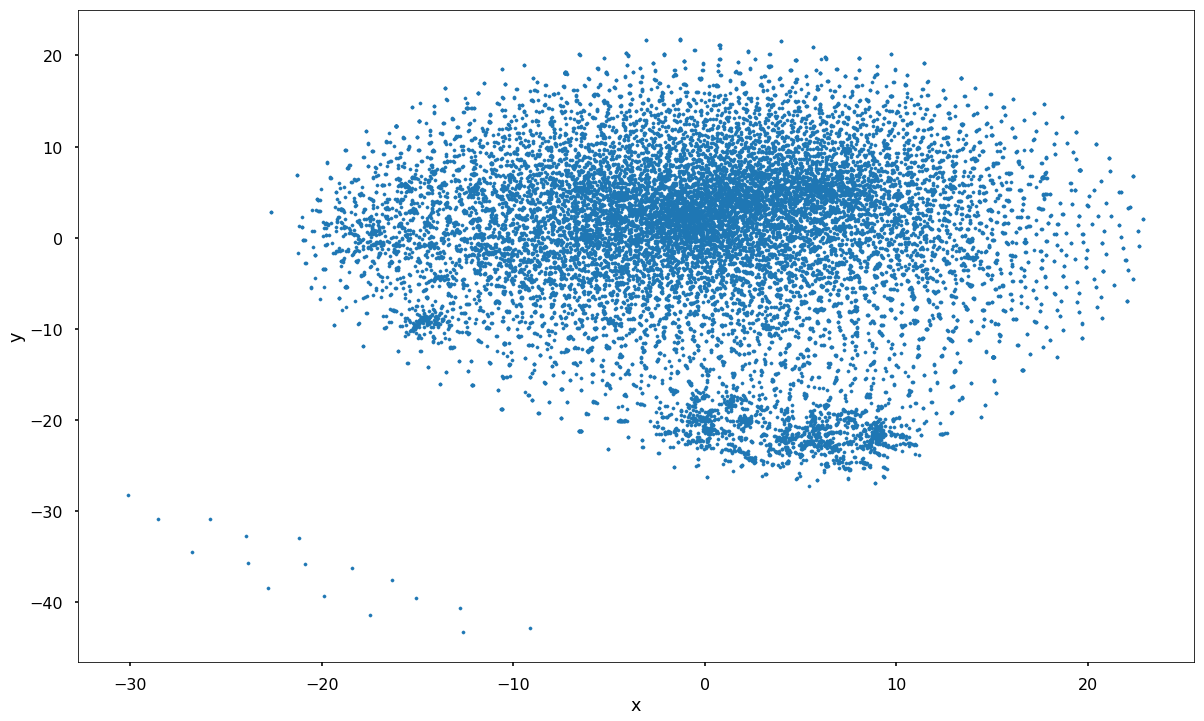

In [29]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [33]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

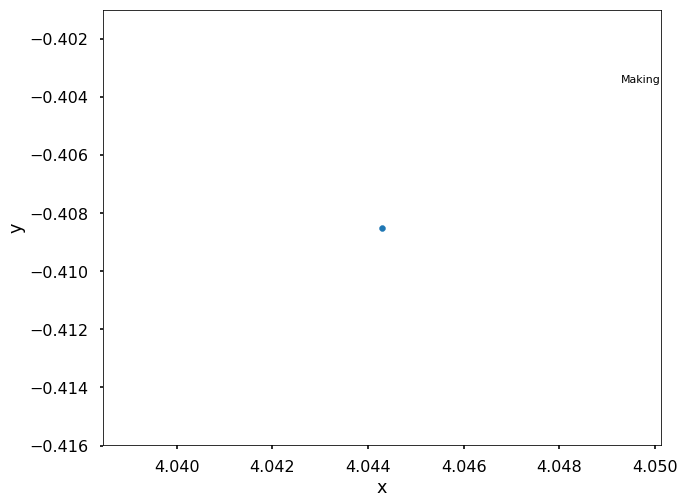

In [34]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

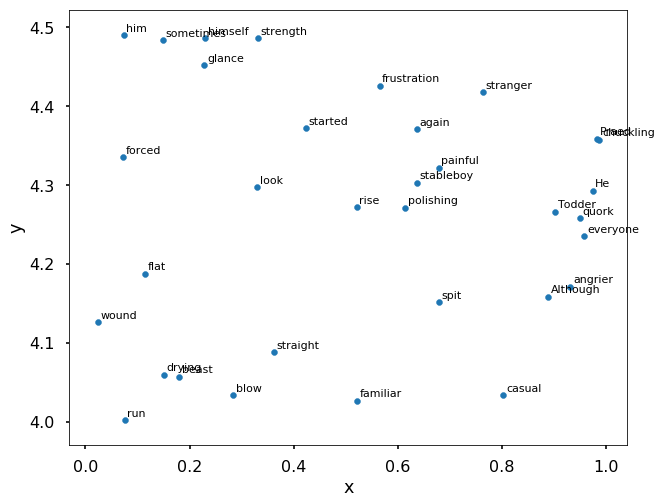

In [35]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

In [38]:
thrones2vec.wv.most_similar("Theon")

[(u'Greyjoy', 0.6053146719932556),
 (u'Turncloak', 0.4441976249217987),
 (u'Reek', 0.41568541526794434),
 (u'Bran', 0.37727996706962585),
 (u'Asha', 0.377045601606369),
 (u'WEX', 0.35713598132133484),
 (u'Victarion', 0.35197198390960693),
 (u'Wex', 0.34540843963623047),
 (u'Ramsay', 0.3375827372074127),
 (u'MARON', 0.3326583504676819)]

In [39]:
thrones2vec.wv.most_similar("Dragons")

[(u'Mother', 0.49305495619773865),
 (u'Shackles', 0.46274834871292114),
 (u'Unburnt', 0.4377765655517578),
 (u'Stormborn', 0.39132052659988403),
 (u'Daenerys', 0.37493619322776794),
 (u'STORMBORN', 0.34990164637565613),
 (u'Tourmaline', 0.34647664427757263),
 (u'UNBURNT', 0.34616079926490784),
 (u'Breaker', 0.33048564195632935),
 (u'WATER', 0.3298369348049164)]

In [40]:
thrones2vec.wv.most_similar("direwolf")

[(u'WIND', 0.45944544672966003),
 (u'GHOST', 0.44417932629585266),
 (u'SHAGGYDOG', 0.44377678632736206),
 (u'EDDISON', 0.40545153617858887),
 (u'wolf', 0.40018555521965027),
 (u'TOLLETT', 0.39647233486175537),
 (u'DOLOROUS', 0.3931411802768707),
 (u'RICKON', 0.3910238444805145),
 (u'Ghost', 0.38172677159309387),
 (u'EDD', 0.3797280490398407)]

In [43]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [44]:
nearest_similarity_cosmul("Stark", "Winterfell", "Martell")
nearest_similarity_cosmul("Stark", "Winterfell", "Bolton")
nearest_similarity_cosmul("Arya", "Horseface", "Daenerys")
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")
nearest_similarity_cosmul("Jon", "Snow", "Ellaria")

Stark is related to Winterfell, as Doran is related to Martell
Stark is related to Winterfell, as Roose is related to Bolton
Arya is related to Horseface, as Dany is related to Daenerys
Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as cup is related to wine
Arya is related to Nymeria, as wyrms is related to dragons
Jon is related to Snow, as Sand is related to Ellaria


u'Sand'

In [45]:
thrones2vec.wv.doesnt_match("Robb Jon Arya Sansa Rickon Brandon".split())

'Brandon'

In [46]:
thrones2vec.wv.doesnt_match("Tyrion Daenerys Gendry Bran Jon".split())

'Daenerys'

In [47]:
thrones2vec.wv.doesnt_match("Jaime Cersei Robert".split())

'Robert'

In [48]:
thrones2vec.wv.doesnt_match("Ramsay Jon Ellaria ".split()) 

'Ellaria'